In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
columns = ['PERMIT_ID', 'UNITS', 'NET_UNITS', 'BESTSTAT', 'BESTDATE', 'YEAR', 'QUARTER']
# AFF_UNITS, NET_AFF_UNITS, NAMEADDR, APN
distinct_columns = ['PERMIT_ID']

def loadData():
    file_name = "data_complete/PipelineCleaned_"
    data = []
    for year in range(2014, 2018):
        for q in range(1, 5):
            if year == 2017 and q == 2:
                break
            X = pd.read_csv(file_name + str(year) + "_Q" + str(q) + ".csv", sep=',', infer_datetime_format=True)
            X["YEAR"] = year
            X["QUARTER"] = q
            data.append(X)
    df = pd.concat(data)
    return df

def loadPermits():
    converters = {'Permit Number': lambda x: 'N'+x.replace(',','')}
    X = pd.read_csv("data_complete/Building_Permits_Filtered.csv", sep=',', infer_datetime_format=True, parse_dates=['PERMIT_DATE', 'PERMIT_STATUS_DATE'])
    X = X.set_index('PERMIT_ID')
    return X

permits = loadPermits()
    
df = loadData()
#print(df.head())
df = df[columns]
df["BESTSTAT"] = df["BESTSTAT"].str.upper()
df["BESTSTAT"][(df["BESTSTAT"] == "BP APPROVED") | (df["BESTSTAT"] == "PL APPROVED")] = "APPROVED"
df["BESTSTAT"][(df["BESTSTAT"] == "BP FILED") | (df["BESTSTAT"] == "PL FILED")] = "FILED"
df = df[df["BESTSTAT"] == "CONSTRUCTION"]
df.drop(["BESTSTAT"], inplace=True, axis=1)
df['BESTDATE'] = pd.to_datetime(df['BESTDATE'], errors='coerce') # format='%m/%d/%Y', 
df.head()
#df.groupby("BESTSTAT").count()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PERMIT_ID,UNITS,NET_UNITS,BESTDATE,YEAR,QUARTER
1,N200505273609,1,1,2014-01-24,2014,1
4,N200608179803,2,1,2014-02-04,2014,1
7,N200605111391,2,2,2014-03-18,2014,1
11,N200904065665,6,6,2013-01-08,2014,1
18,N201205180774,37,37,2014-01-08,2014,1


In [4]:
#df[(df["BESTSTAT"] == "CONSTRUCTION") & (df["YEAR"] == 2014)].sort_values(by=['NET_UNITS'], ascending=False)
#construction_start = df.sort(['BESTDATE', 'YEAR', 'QUARTER']).drop_duplicates(subset=distinct_columns, keep="first")
construction_start = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=distinct_columns, keep="first")
#construction_start.rename(columns = {'BESTDATE':'STARTDATE'}, inplace = True)

construction_end = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=distinct_columns, keep="last")
#construction_end.rename(columns = {'BESTDATE':'ENDDATE'}, inplace = True)


data = pd.merge(construction_start[['PERMIT_ID', 'YEAR', 'QUARTER']], construction_end, 
                how='inner', on=['PERMIT_ID'], left_on=None, right_on=None, suffixes=('_START', '_END'))
# not applicable as BESTDATE seems not to be updated 
#data['DURATION'] = (data['ENDDATE'] - data['STARTDATE']) / np.timedelta64(1, 'D')

data = data[~data.duplicated('PERMIT_ID')]

data = data.set_index('PERMIT_ID')

print(len(data))
data = data.join(permits, how='inner')
print(len(data))

data['PERMIT_DATE_YEAR'] = pd.DatetimeIndex(data['PERMIT_DATE']).year
data['PERMIT_DATE_QUARTER'] = pd.DatetimeIndex(data['PERMIT_DATE']).quarter

data['DURATION'] = (data['YEAR_END'] - data['PERMIT_DATE_YEAR']) * 4 + data['QUARTER_END'] - data['PERMIT_DATE_QUARTER'] + 1
data = data[['UNITS', 'NET_UNITS', 'YEAR_START', 'QUARTER_START', 'YEAR_END', 'QUARTER_END', 'DURATION', 'PERMIT_DATE', 'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER', 'PERMIT_STATUS', 'PERMIT_STATUS_DATE']]
data.head()

565
689


,UNITS,NET_UNITS,YEAR_START,QUARTER_START,YEAR_END,QUARTER_END,DURATION,PERMIT_DATE,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,PERMIT_STATUS,PERMIT_STATUS_DATE
PERMIT_ID,,,,,,,,,,,,
N200201106632,3,3,2014,1,2015,4,56,2002-01-10,2002,1,issued,05/17/2004
N200207171660,8,8,2014,1,2015,4,54,2002-07-17,2002,3,issued,01/12/2005
N200212244171,81,71,2014,1,2014,2,47,2002-12-24,2002,4,complete,08/28/2014
N200311240936,1,1,2014,1,2015,4,49,2003-11-24,2003,4,issued,09/28/2011
N200312243005,2,2,2014,1,2015,2,47,2003-12-24,2003,4,complete,09/21/2015


In [5]:
print(data.count())
print(data[data['DURATION'] > 1].count())
#data = data[data['DURATION'] > 0]
#g = data.groupby(['PERMIT_ID'])
#data = g.filter(lambda x: len(x) == 2)

UNITS                  689
NET_UNITS              689
YEAR_START             689
QUARTER_START          689
YEAR_END               689
QUARTER_END            689
DURATION               689
PERMIT_DATE            689
PERMIT_DATE_YEAR       689
PERMIT_DATE_QUARTER    689
PERMIT_STATUS          689
PERMIT_STATUS_DATE     689
dtype: int64
UNITS                  689
NET_UNITS              689
YEAR_START             689
QUARTER_START          689
YEAR_END               689
QUARTER_END            689
DURATION               689
PERMIT_DATE            689
PERMIT_DATE_YEAR       689
PERMIT_DATE_QUARTER    689
PERMIT_STATUS          689
PERMIT_STATUS_DATE     689
dtype: int64


In [6]:
not_completed_ids = data[(data['YEAR_END'] == 2017)].index
complete = data[~data.index.isin(not_completed_ids)]
incomplete = data[data.index.isin(not_completed_ids)]
print(complete.count())
print(incomplete.count())

UNITS                  468
NET_UNITS              468
YEAR_START             468
QUARTER_START          468
YEAR_END               468
QUARTER_END            468
DURATION               468
PERMIT_DATE            468
PERMIT_DATE_YEAR       468
PERMIT_DATE_QUARTER    468
PERMIT_STATUS          468
PERMIT_STATUS_DATE     468
dtype: int64
UNITS                  221
NET_UNITS              221
YEAR_START             221
QUARTER_START          221
YEAR_END               221
QUARTER_END            221
DURATION               221
PERMIT_DATE            221
PERMIT_DATE_YEAR       221
PERMIT_DATE_QUARTER    221
PERMIT_STATUS          221
PERMIT_STATUS_DATE     221
dtype: int64


In [7]:
complete.sort_values(['NET_UNITS'], ascending=False)

,UNITS,NET_UNITS,YEAR_START,QUARTER_START,YEAR_END,QUARTER_END,DURATION,PERMIT_DATE,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,PERMIT_STATUS,PERMIT_STATUS_DATE
PERMIT_ID,,,,,,,,,,,,
N201207124717,656,656,2014,2,2016,1,15,2012-07-12,2012,3,issued,05/29/2013
N201306250394,560,560,2014,4,2016,3,14,2013-06-25,2013,2,issued,07/08/2014
N201112070227,470,470,2014,4,2016,3,20,2011-12-07,2011,4,complete,05/15/2017
N200605161774,452,452,2014,3,2015,4,39,2006-05-16,2006,2,complete,02/10/2017
N201209059006,450,450,2014,1,2016,2,16,2012-09-05,2012,3,issued,08/02/2013
N201307303137,416,416,2014,4,2016,4,14,2013-07-30,2013,3,issued,03/20/2014
N201304023626,409,409,2014,2,2015,3,10,2013-04-02,2013,2,complete,02/09/2017
N201208026344,399,399,2014,1,2014,4,10,2012-08-02,2012,3,complete,09/29/2016
N201112070234,393,393,2014,3,2016,1,18,2011-12-07,2011,4,complete,05/18/2017


In [8]:
print("Median ", complete['DURATION'].median())
print("Mean ", str(complete['DURATION'].mean()))

print("Median net units", complete['NET_UNITS'].median()) # few big buildings
#print("Long in costruction, net units: ", complete[complete['DURATION'] > 4]['NET_UNITS'].mean())
#print("Not long in costruction, net units: ", complete[complete['DURATION'] <= 4]['NET_UNITS'].mean())

# not much difference
print("\nBigger buildings: ", complete[complete['NET_UNITS'] > 20]['DURATION'].mean())
print("Smaller buildings: ", complete[complete['NET_UNITS'] <= 20]['DURATION'].mean())

print("Bigger buildings: ", complete[complete['NET_UNITS'] > 20]['DURATION'].median())
print("Smaller buildings: ", complete[complete['NET_UNITS'] <= 20]['DURATION'].median())

Median  13.0
Mean  17.664529914529915
Median net units 2.0

Bigger buildings:  18.72826086956522
Smaller buildings:  17.404255319148938
Bigger buildings:  14.0
Smaller buildings:  13.0


In [9]:
# complete = complete[complete['DURATION'] > 1] # remove 1-quarter buildings
# complete = complete[(complete['YEAR_START'] == 2014) & (complete['QUARTER_START'] > 1) | (complete['YEAR_START'] > 2014)]

In [10]:
print("Median ", complete['DURATION'].median())
print("Mean ", str(complete['DURATION'].mean()))

print("\nBigger buildings: ", complete[complete['NET_UNITS'] > 40]['DURATION'].mean())
print("\nBigger buildings: ", complete[complete['NET_UNITS'] > 100]['DURATION'].mean())
print("Smaller buildings: ", complete[complete['NET_UNITS'] <= 40]['DURATION'].mean())

print("Bigger buildings: ", complete[complete['NET_UNITS'] > 40]['DURATION'].median())
print("Bigger buildings: ", complete[complete['NET_UNITS'] > 100]['DURATION'].median())
print("Smaller buildings: ", complete[complete['NET_UNITS'] <= 40]['DURATION'].median())

Median  13.0
Mean  17.664529914529915

Bigger buildings:  17.53846153846154

Bigger buildings:  16.522727272727273
Smaller buildings:  17.684863523573203
Bigger buildings:  13.0
Bigger buildings:  13.0
Smaller buildings:  13.0


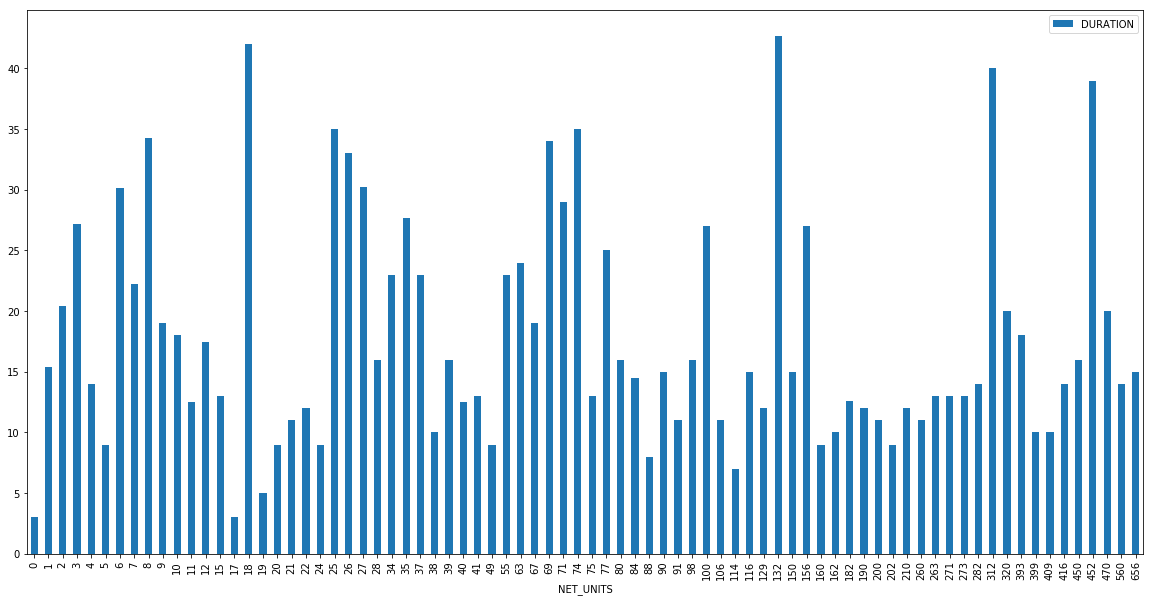

In [11]:
# net units to duration
# df.groupby(['cluster']).mean()
# complete.sort_values(['NET_UNITS']).groupby(['NET_UNITS']).mean().plot(x = 'NET_UNITS', y = 'DURATION', kind = "bar", figsize=(20,10))

grouped = complete.sort_values(['NET_UNITS']).groupby(['NET_UNITS']).mean()
grouped.plot(y = 'DURATION', kind = "bar", figsize=(20,10))

In [12]:
# data["N200903134091"]

Approved permits in the last quarter with construction not started

In [13]:
complete.sort_values(['NET_UNITS'], ascending=False).head()

,UNITS,NET_UNITS,YEAR_START,QUARTER_START,YEAR_END,QUARTER_END,DURATION,PERMIT_DATE,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,PERMIT_STATUS,PERMIT_STATUS_DATE
PERMIT_ID,,,,,,,,,,,,
N201207124717,656,656,2014,2,2016,1,15,2012-07-12,2012,3,issued,05/29/2013
N201306250394,560,560,2014,4,2016,3,14,2013-06-25,2013,2,issued,07/08/2014
N201112070227,470,470,2014,4,2016,3,20,2011-12-07,2011,4,complete,05/15/2017
N200605161774,452,452,2014,3,2015,4,39,2006-05-16,2006,2,complete,02/10/2017
N201209059006,450,450,2014,1,2016,2,16,2012-09-05,2012,3,issued,08/02/2013


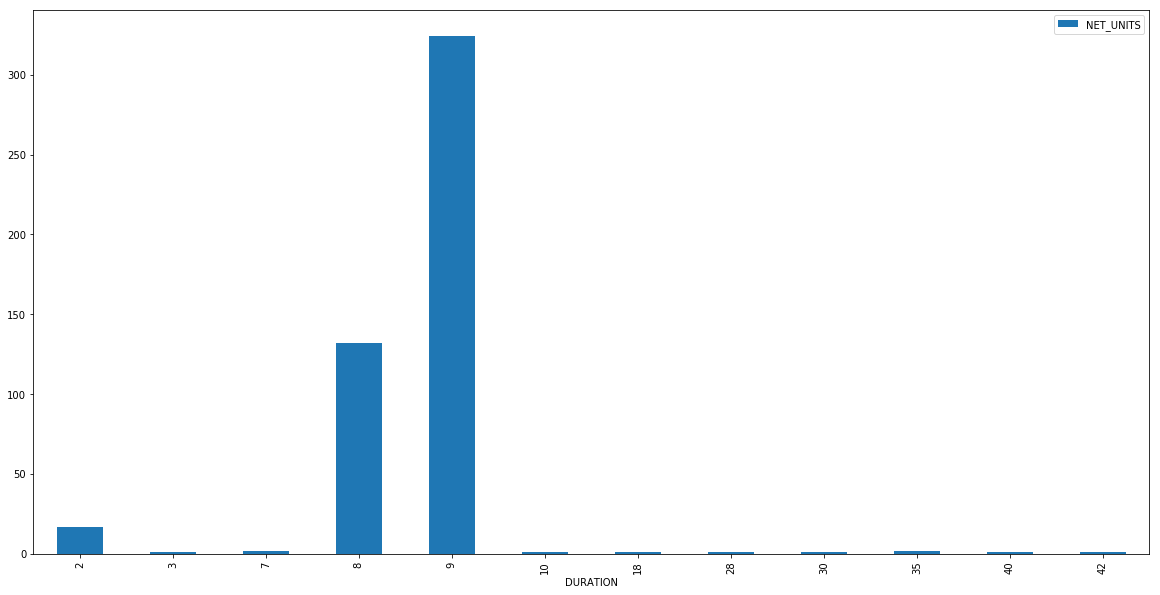

In [14]:
d1 = complete[complete['YEAR_END'] == 2015]
d1 = d1[d1['QUARTER_END'] == 1]
grouped = d1.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10))

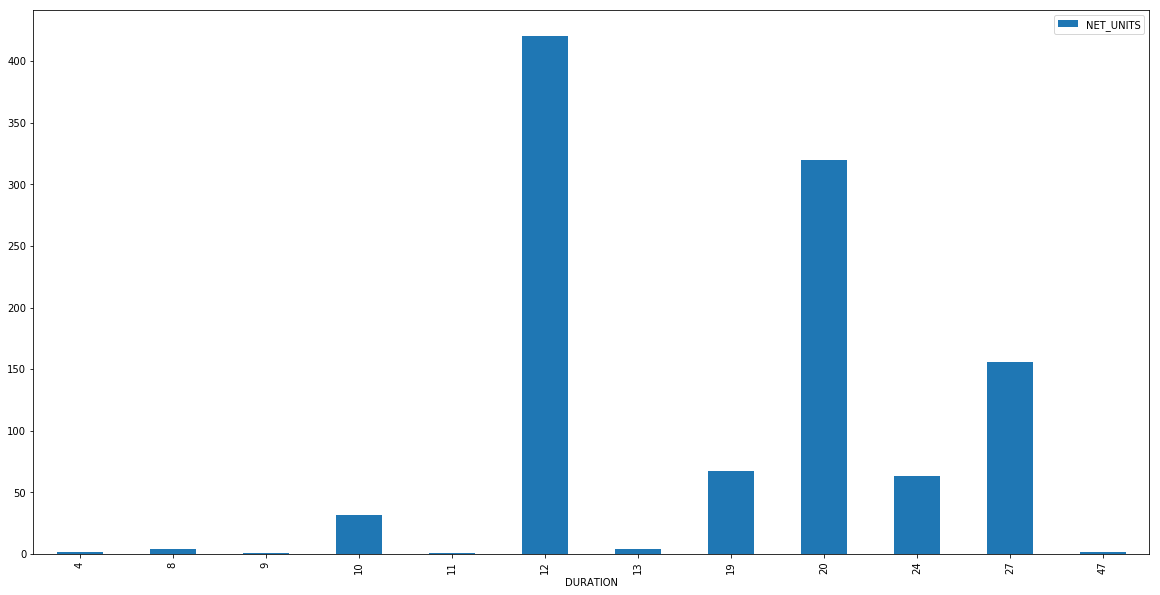

In [15]:
d1 = complete[complete['YEAR_END'] == 2015]
d1 = d1[d1['QUARTER_END'] == 2]
grouped = d1.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10))

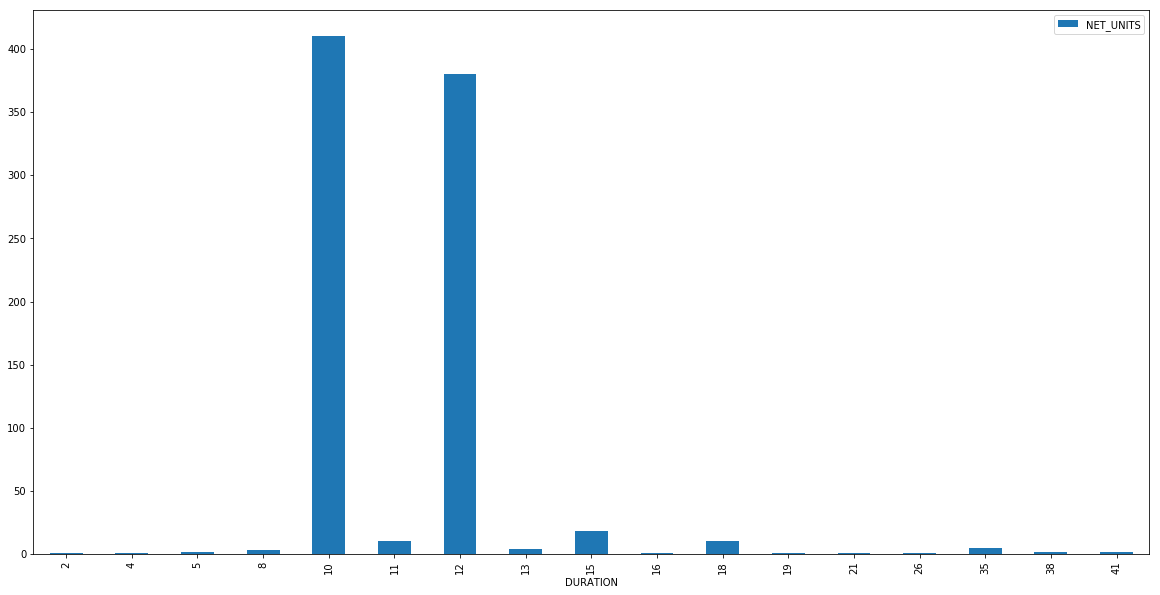

In [16]:
d1 = complete[complete['YEAR_END'] == 2015]
d1 = d1[d1['QUARTER_END'] == 3]
grouped = d1.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10))

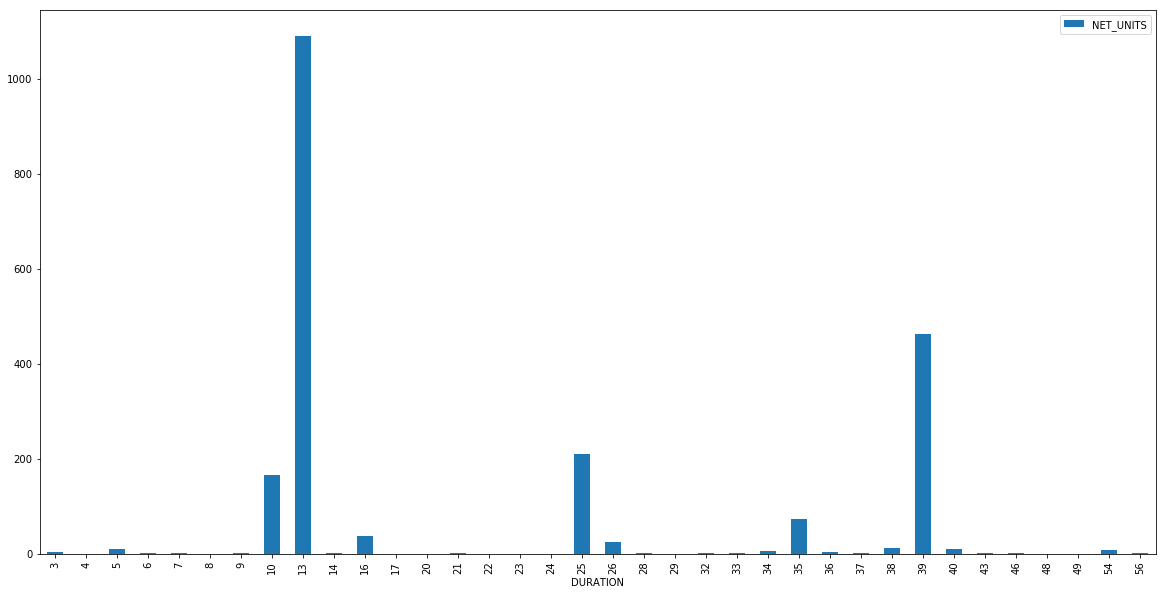

In [17]:
d1 = complete[complete['YEAR_END'] == 2015]
d1 = d1[d1['QUARTER_END'] == 4]
grouped = d1.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10))

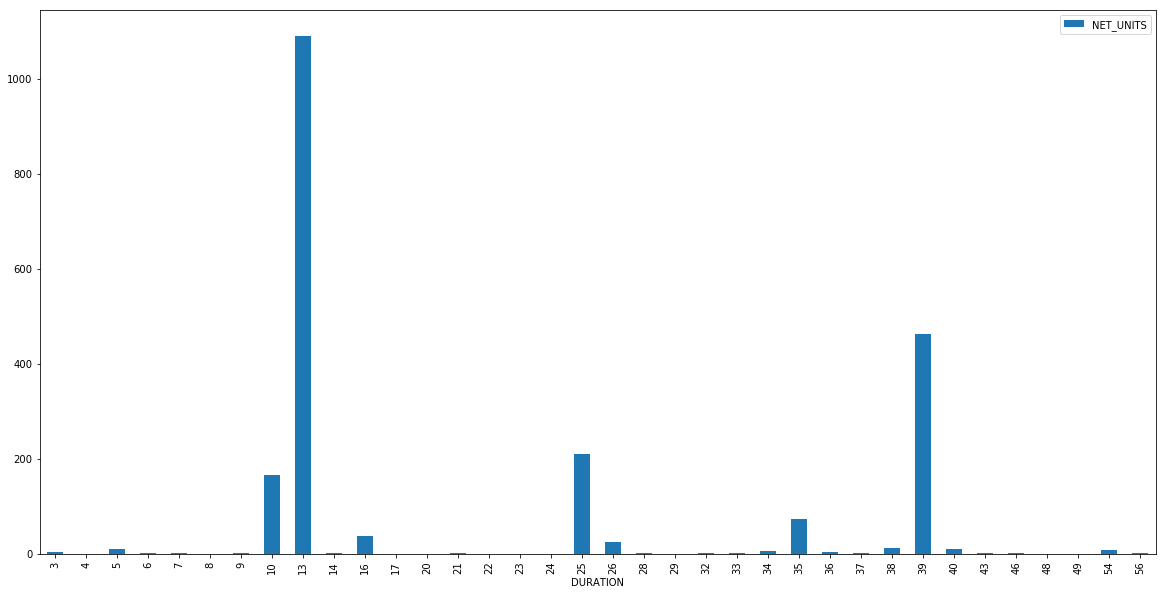

In [18]:
d1 = complete[complete['YEAR_END'] == 2015]
d1 = d1[d1['QUARTER_END'] == 4]
grouped = d1.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10))

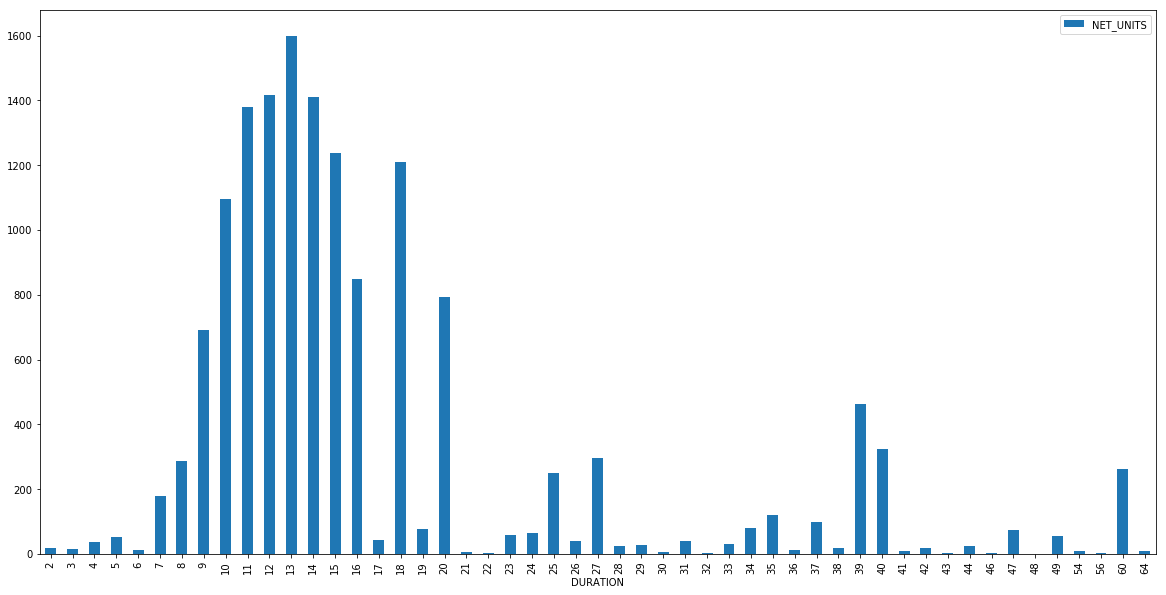

In [19]:
grouped = complete.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10))